# Inference for small GW strains

We have been generating timeseries and corner plots assuming some un-physically large value of the GW strain $h$.

What happens if we use these same techniques for smaller strains?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

## 1. Example Kalman filterings

We can generate some synthetic data, and run the Kalman filter to see how well we recover the state.

The Kalman filter depends on a series of physical parameters (e.g. GW angular frequency). 

Lets assume we know these perfectly, and see how the filter does.

In [3]:
from system_parameters import SystemParameters
from pulsars import Pulsars

from synthetic_data import SyntheticData
from plotting import plot_statespace,plot_all
from model import LinearModel
from kalman_filter import KalmanFilter
from bilby_wrapper import BilbySampler
from priors import priors_dict,bilby_priors_dict

### 1.1. Canonical example

Attention: You are including the PSR terms in your synthetic data generation
Attention: You are including the PSR terms in your measurement model
Model likelihood is:  3811847.1905475354795
Mean residual: 2.6930398550442619935e-15


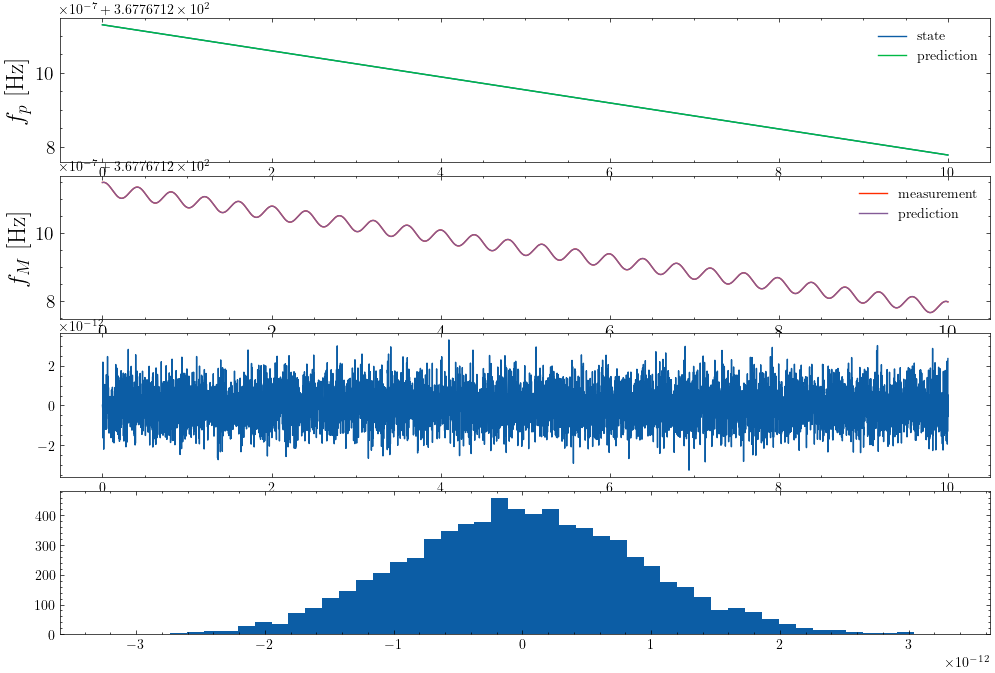

In [7]:
import numpy as np 

P    = SystemParameters(h=1e-10,σp=1e-15,σm=1e-12,Npsr=20,cadence=0.5,NF=np.longdouble)       #define the system parameters as a class
PTA  = Pulsars(P)               # setup the PTA
data = SyntheticData(PTA,P) # generate some synthetic data

#Define the model 
model = LinearModel(P)

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)

# Run the KFwith the correct parameters
true_parameters = priors_dict(PTA,P)
model_likelihood, model_state_predictions_x,model_state_predictions_y = KF.likelihood(true_parameters)
print("Model likelihood is: ", model_likelihood)
plot_all(PTA.t, data.intrinsic_frequency, data.f_measured, model_state_predictions_x,model_state_predictions_y, 1,savefig=None)


### 1.2. Drop float precision to `float64`


Note that we are working here using a long double. If we use the usual float64:

Attention: You are including the PSR terms in your synthetic data generation
Attention: You are including the PSR terms in your measurement model
Model likelihood is:  3811751.3882791777
Mean residual: 3.161428501025761e-15


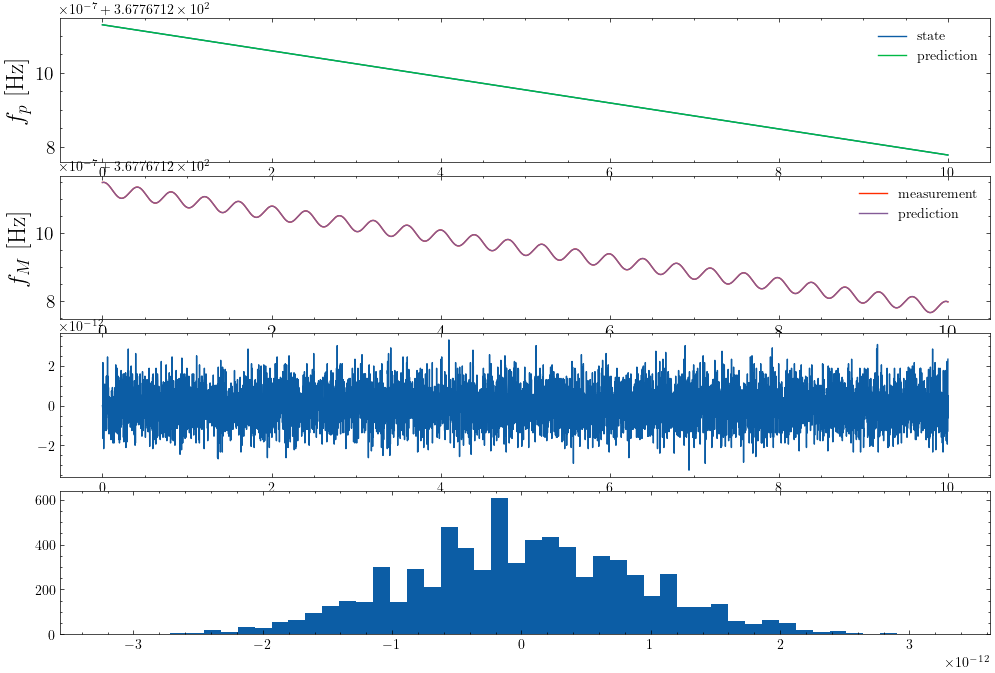

In [8]:
import numpy as np 

P    = SystemParameters(h=1e-10,σp=1e-15,σm=1e-12,Npsr=20,cadence=0.5,NF=np.float64)       #define the system parameters as a class
PTA  = Pulsars(P)               # setup the PTA
data = SyntheticData(PTA,P) # generate some synthetic data

#Define the model 
model = LinearModel(P)

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)

# Run the KFwith the correct parameters
true_parameters = priors_dict(PTA,P)
model_likelihood, model_state_predictions_x,model_state_predictions_y = KF.likelihood(true_parameters)
print("Model likelihood is: ", model_likelihood)
plot_all(PTA.t, data.intrinsic_frequency, data.f_measured, model_state_predictions_x,model_state_predictions_y, 1,savefig=None)


### 1.3 Drop the measurement noise 
If we make the measurement noise too small then we hit numerical issues, even when using `longdouble`

Model likelihood is:  4056060.933602742743
Mean residual: 4.780802846450930938e-17


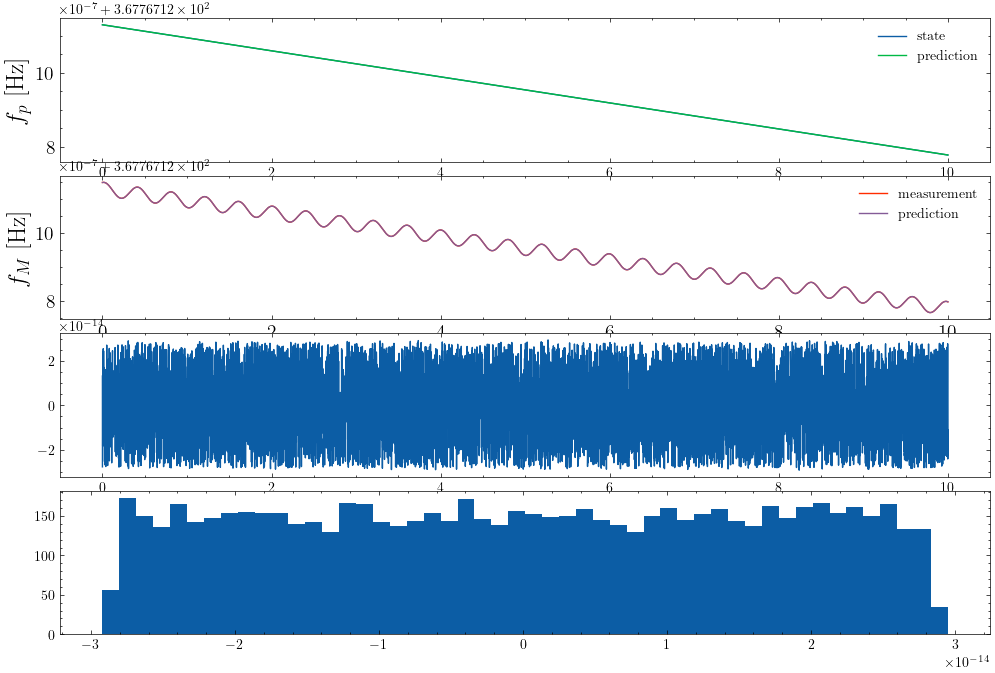

In [64]:
import numpy as np 

P    = SystemParameters(h=1e-10,σp=1e-15,σm=1e-14,Npsr=20,cadence=0.5,NF=np.longdouble)       #define the system parameters as a class
PTA  = Pulsars(P)               # setup the PTA
data = SyntheticData(PTA,P) # generate some synthetic data

#Define the model 
model = LinearModel

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)

# Run the KFwith the correct parameters
true_parameters = priors_dict(PTA,P)
model_likelihood, model_state_predictions_x,model_state_predictions_y = KF.likelihood(true_parameters)
print("Model likelihood is: ", model_likelihood)
plot_all(PTA.t, data.intrinsic_frequency, data.f_measured, model_state_predictions_x,model_state_predictions_y, 1,savefig=None)


### 1.4 Canonical example with wrong parameters

Model likelihood is:  -142802954887.76188867
Mean residual: 1.7066017739017388677e-12


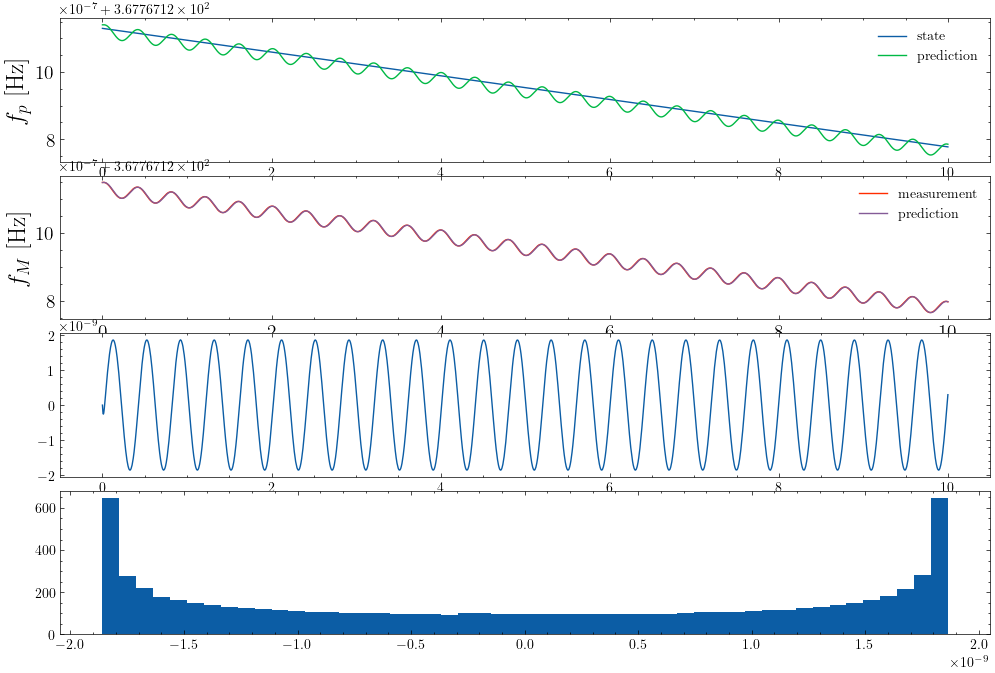

In [65]:
import numpy as np 

P    = SystemParameters(h=1e-10,σp=1e-15,σm=1e-12,Npsr=20,cadence=0.5,NF=np.longdouble)       #define the system parameters as a class
PTA  = Pulsars(P)               # setup the PTA
data = SyntheticData(PTA,P) # generate some synthetic data

#Define the model 
model = LinearModel

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)

# Run the KFwith the correct parameters
true_parameters = priors_dict(PTA,P)

wrong_parameters = true_parameters.copy()
wrong_parameters["omega_gw"] =1e-9 #Change one of the parameters which is fed to the KF

model_likelihood, model_state_predictions_x,model_state_predictions_y = KF.likelihood(wrong_parameters)
print("Model likelihood is: ", model_likelihood)
plot_all(PTA.t, data.intrinsic_frequency, data.f_measured, model_state_predictions_x,model_state_predictions_y, 1,savefig=None)


## 2. Parameter estimation using nested sampling

When working with small strains we need to be more mindful of the noise parameters that we use

The measurement noise is

$$ \sigma_m = f \frac{\sigma_{\rm TOA}}{\rm cadence}$$

So for a MSP ( $f \sim 100 Hz$) observed with a weekly cadence and $\sigma_{\rm TOA} \sim 1 \mu$ s:

In [66]:
sigma_m = lambda f,sigma,cadence: f*sigma/(cadence*7*24*3600)
sigma_m(100,1e-6,1)

1.6534391534391532e-10

The very best pulsars might have $\sigma_{\rm TOA} \sim 10 ns$

In [67]:
sigma_m(100,10e-9,1)

1.6534391534391534e-12

Lets take $\sigma_m \sim 10^{-11}$ as a canonical value that applies to all pulsars.

Determining $\sigma_p$ is a bit more uncertain. Our current method is quite qualitative and uses the same approach as in Vargas & Melatos. This method is 

1.  Choose a $\sigma_p$ value
2. For a particular pulsar use this $\sigma_p$ to generate some residuals 
3. Compare these residuals to the true pulsar residuals. Are they qualitatively similar?


The plot below is generated with a $\sigma_p \sim 10^{-20}$ 

![localImage](../data/images/example_sigma_p.png)

Whereas this next plot is for $\sigma_p \sim 10^{-15}$ 

![localImage](../data/images/example_Sigma_p_2.png)

...and for $\sigma_p \sim 10^{-10}$ 

![localImage](../data/images/example_1.png)


At such small values of $\sigma_p$ and $\sigma_m$ we are going to run into numerical issues: 

In [68]:
sigma_p = 1e-20 
sigma_m = 1e-11 



#Predict step
y_before = 1.0
y_after = y_before + sigma_p**2

print("Does y_before = y_after for the process noise:", y_after == y_before)

#Update step
y_before = 1.0
y_after = y_before + sigma_m**2

print("Does y_before = y_after for the measurement noise:", y_after == y_before)

Does y_before = y_after for the process noise: True
Does y_before = y_after for the measurement noise: True


### 2.1 Few parameters 

Number of samples:
399
Medians/Variances
omega_gw 4.999999999856576e-07 1.573840569282285e-34
phi0_gw 0.2000039495404265 2.6553025143412055e-12


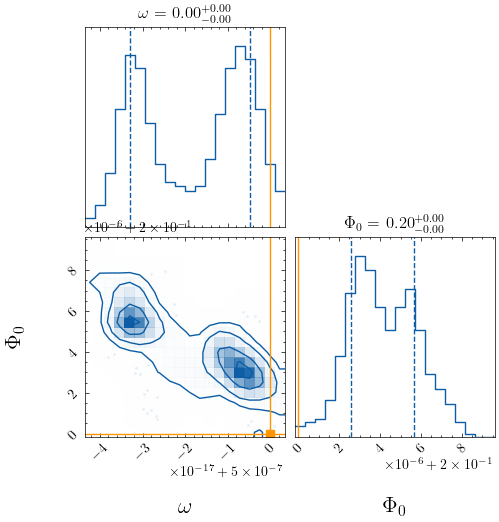

In [70]:
from plotting import plot_custom_corner
import numpy as np 

path = "../data/nested_sampling/small_h_experiment_1_result.json" #(h=1e-10,σm=1e-12,σp=1e-15,Npsr=20) 

injection_parameters = [5e-7,0.20]
labels = [r'$\omega$',r'$\Phi_0$']
variables_to_plot = ["omega_gw","phi0_gw"]
ranges=None
axes_scales=None
plot_custom_corner(path,variables_to_plot,labels,injection_parameters,ranges,axes_scales,savefig=None)


### 2.1 Many parameters

Number of samples:
99
Medians/Variances
omega_gw 4.991673436390273e-07 0.0
Note!  omega_gw  has zero variance and will not be plotted
phi0_gw 0.4794699178033974 9.734202021619357e-21
psi_gw 2.50986700775808 4.839496540389383e-20
iota_gw 0.902095137358801 1.0321743060969897e-19
delta_gw 1.0631754951701708 1.384581694680323e-29
alpha_gw 0.8273088258974104 3.3317927719061103e-29
h 8.678199351001327e-11 0.0
Note!  h  has zero variance and will not be plotted


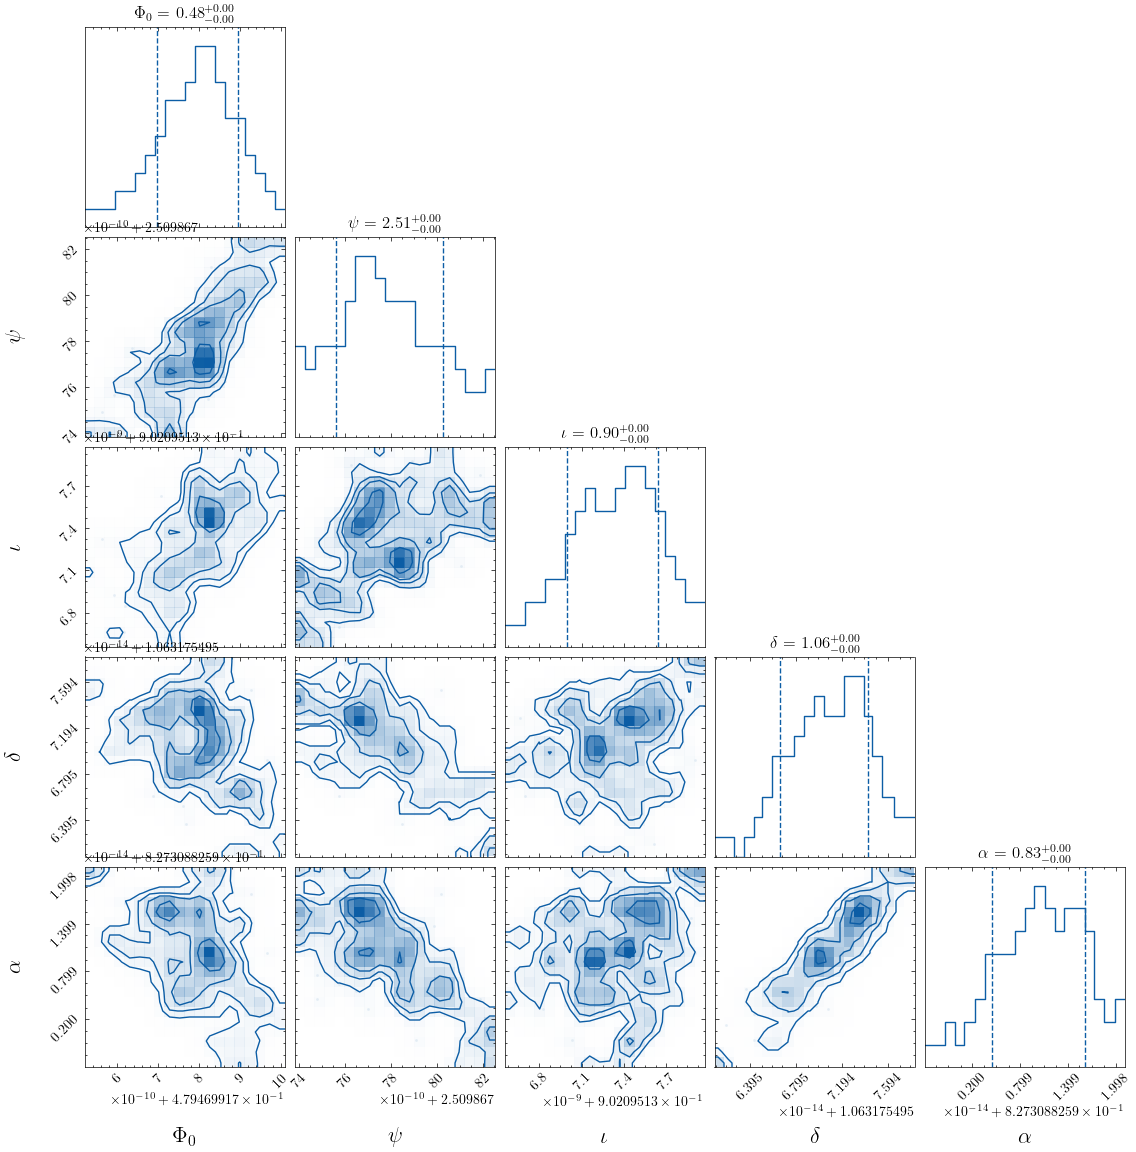

In [9]:
from plotting import plot_custom_corner
import numpy as np 

path = "../data/nested_sampling/small_h_experiment_3_result.json" #(h=1e-10,σm=1e-12,σp=1e-15,Npsr=20) 



injection_parameters = [5e-7,0.20,2.50,1.0,1.0,1.0,1e-10]
labels = [r'$\omega$',r'$\Phi_0$',r'$\psi$',r'$\iota$', r'$\delta$',r'$\alpha$',r'h']
variables_to_plot = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]

ranges=None
axes_scales=None

plot_custom_corner(path,variables_to_plot,labels,injection_parameters,ranges,axes_scales,savefig=None)


Clearly we are having some issues getting nice posteriors.

In particular the posteriors are WAY too narrow. Why is this?

Our likelihood surface is very complex. Is this causing issues? See `likelihood_surfaces_scaling.ipynb`


## Appendix 

c.f. float numerical issues, how do two state evolutions look with different (small) process noise? 

In [16]:
import numpy as np 
from system_parameters import SystemParameters
from pulsars import Pulsars

from synthetic_data import SyntheticData
from plotting import plot_statespace,plot_all
from model import LinearModel
from kalman_filter import KalmanFilter
from bilby_wrapper import BilbySampler
from priors import priors_dict,bilby_priors_dict



P1    = SystemParameters(h=1e-10,σp=1e-8,σm=1e-12,Npsr=20)       #define the system parameters as a class
PTA1  = Pulsars(P1)               # setup the PTA
data1 = SyntheticData(PTA1,P1) # generate some synthetic data



P2    = SystemParameters(h=1e-10,σp=1e-16,σm=1e-12,Npsr=20)       #define the system parameters as a class
PTA2  = Pulsars(P2)               # setup the PTA
data2 = SyntheticData(PTA2,P1) # generate some synthetic data

Attention: You are including the PSR terms in your synthetic data generation
Attention: You are including the PSR terms in your synthetic data generation


[]

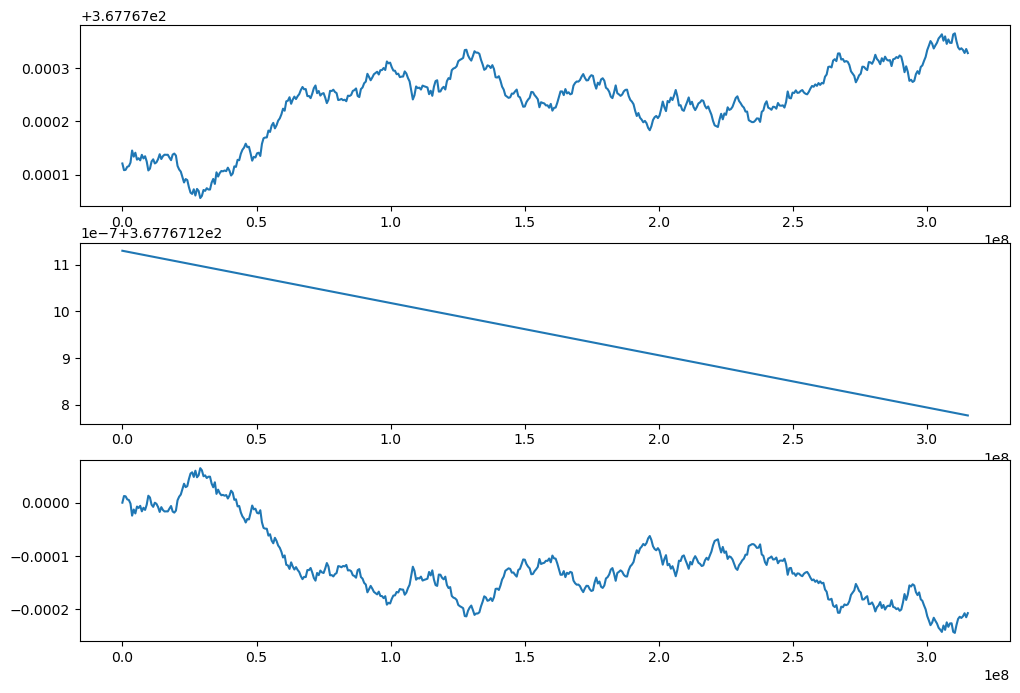

In [17]:
y1 = data1.intrinsic_frequency
y2 = data2.intrinsic_frequency



import matplotlib.pyplot as plt 
tplot = PTA1.t

psr_index = 1
h,w = 12,8
rows = 3
cols = 1
fig, (ax1,ax2,ax3) = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=False)

ax1.plot(tplot,y1[:,psr_index])
ax2.plot(tplot,y2[:,psr_index])
ax3.plot(tplot,y2[:,psr_index]-y1[:,psr_index])


plt.plot()
